## Access ARGO data in Parquet

A jupyter notebook to show how to access and plot ARGO Core data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [6]:
dataset_name = "argo"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session and comment the next 3 lines
!pip install s3fs -U
!pip install pyarrow==16.0.0 -U
!pip install zarr xarray[complete]
!pip install pandas==2.2.2 -U

In [7]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/parquet_queries.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [8]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [9]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"
dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/cloud_optimised/cluster_testing/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [10]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

timestamp: int32
PLATFORM_NUMBER: int32
polygon: string


## List unique partition values

In [15]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'PLATFORM_NUMBER')
print(list(unique_partition_value)[0:2])  # showing a subset only
len(unique_partition_value)

['5900029', '2902658']
CPU times: user 178 ms, sys: 33 µs, total: 178 ms
Wall time: 182 ms


3695

## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

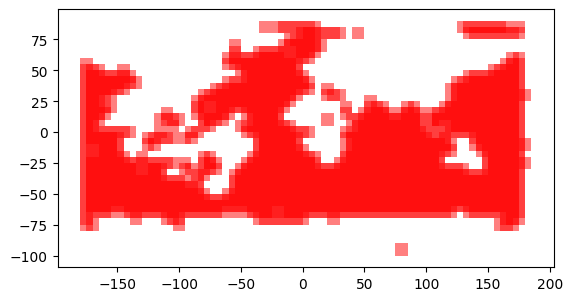

In [12]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [13]:
get_temporal_extent(parquet_ds)

(datetime.datetime(1998, 1, 1, 11, 0), datetime.datetime(2024, 1, 1, 11, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [14]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
get_schema_metadata(dname)  # schema metadata

{'DATA_TYPE': {'type': 'string',
  'long_name': 'Data type',
  'conventions': 'Argo reference table 1'},
 'FORMAT_VERSION': {'type': 'string', 'long_name': 'File format version'},
 'HANDBOOK_VERSION': {'type': 'string', 'long_name': 'Data handbook version'},
 'REFERENCE_DATE_TIME': {'type': 'string',
  'long_name': 'Date of reference for Julian days',
  'conventions': 'YYYYMMDDHHMISS'},
 'DATE_CREATION': {'type': 'string',
  'long_name': 'Date of file creation',
  'conventions': 'YYYYMMDDHHMISS'},
 'DATE_UPDATE': {'type': 'string',
  'long_name': 'Date of update of this file',
  'conventions': 'YYYYMMDDHHMISS'},
 'PLATFORM_NUMBER': {'type': 'string',
  'long_name': 'Float unique identifier',
  'conventions': 'WMO float identifier : A9IIIII'},
 'PROJECT_NAME': {'type': 'string', 'long_name': 'Name of the project'},
 'PI_NAME': {'type': 'string',
  'long_name': 'Name of the principal investigator'},
 'STATION_PARAMETERS': {'type': 'string',
  'long_name': 'List of available parameters fo

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
filter_time = create_time_filter(parquet_ds, date_start='2018-12-01', date_end='2023-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)


filter = filter_geo & filter_time

In [11]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

In [12]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')

In [13]:
import matplotlib.pyplot as plt


filtered_df = df[df['PLATFORM_NUMBER'] == 5905506]

# Get unique values of CYCLE_NUMBER
unique_cycle_numbers = filtered_df['CYCLE_NUMBER'].unique()

# Define a dictionary to map each unique CYCLE_NUMBER to a color
color_mapping = {cycle_number: plt.cm.viridis_r(i / len(unique_cycle_numbers)) for i, cycle_number in enumerate(unique_cycle_numbers)}

# Plot TEMP_ADJUSTED vs PRES_ADJUSTED with different colors for each line
for cycle_number, color in color_mapping.items():
    cycle_df = filtered_df[filtered_df['CYCLE_NUMBER'] == cycle_number]
    plt.plot(cycle_df['TEMP_ADJUSTED'], cycle_df['PRES_ADJUSTED'], color=color, label=f'Cycle {cycle_number}')

plt.xlabel('Temperature Adjusted')
plt.ylabel('Pressure Adjusted')
plt.title('Temperature vs Pressure')
plt.legend()
plt.grid(True)

# Reverse the y-axis
plt.gca().invert_yaxis()

plt.show()

## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2006-07-12', date_end='2023-02-05')

expr_1 = pc.field('PLATFORM_NUMBER') == 1901740
filter = expr_1 & filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

In [16]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')